In [126]:
import base64
import mapbox_vector_tile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import os

In [145]:
def get_geometry(detections_url,traffic_signs):
    response = requests.get(detections_url)
    json_data = response.json()
    
    base64_strings = []
    detection_values=[]
    
    for detection in json_data['data']:
        if detection['value'] in traffic_signs:
            base64_string = detection['geometry']
            print(f"Value: {detection['value']}")
            print(f"base64_string: {base64_string}")
            base64_strings.append(base64_string)
            detection_values.append(detection['value'])
    
    return base64_strings,detection_values

In [146]:
def decode_geometry(base64_string):
    decoded_data = base64.decodebytes(base64_string.encode('utf-8'))
    detection_geometry = mapbox_vector_tile.decode(decoded_data)
    return detection_geometry   

In [147]:
def normalize_coordinate(coordinates,extent):
    normalized_coordinates = [[x / extent,1-( y / extent)] for x, y in coordinates]
    return normalized_coordinates


In [148]:
def get_bounding_box(pixel_coordinates):
    min_x = min(point[0] for point in pixel_coordinates)
    max_x = max(point[0] for point in pixel_coordinates)
    min_y = min(point[1] for point in pixel_coordinates)
    max_y = max(point[1] for point in pixel_coordinates)
    return [min_x,min_y,max_x,max_y]

In [149]:
def convert_to_yolo_format(bbox, class_id):
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min
    print(f"Yolo Annotation: {class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"


In [150]:
def process_detections(base64_strings,detection_values):
    all_yolo_annotations = []
    all_bboxes = []

    for base64_string, detection_value in zip(base64_strings, detection_values):
        detection_geometry = decode_geometry(base64_string)
        
        yolo_annotations = []
        bboxes = []
        
        for feature in detection_geometry['mpy-or']['features']:
            extent = detection_geometry['mpy-or']['extent']
            coordinates = feature['geometry']['coordinates'][0]
            normalized_coords = normalize_coordinate(coordinates, extent)
            
            bbox = get_bounding_box(normalized_coords)
            try:
                index = traffic_signs.index(detection_value)
                print(f"detection_value '{detection_value}' found at index: {index}")
            except ValueError:
                print(f"detection_value '{detection_value}' not found in traffic_signs.")
                index = -1 
                
            if index != 1:
                yolo_annotation = convert_to_yolo_format(bbox,index)
            
                yolo_annotations.append(yolo_annotation)
                bboxes.append(bbox)
        
        all_yolo_annotations.extend(yolo_annotations)
        all_bboxes.extend(bboxes)
    
    return all_yolo_annotations, all_bboxes

In [151]:
def visualize_annotations(image_path, bboxes):
    img = Image.open(image_path)
    fig, ax = plt.subplots()
    ax.imshow(img)

    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        rect = plt.Rectangle(((x_min ) * img.width, (y_min ) * img.height), 
                             width * img.width, height * img.height, 
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    plt.show()

In [152]:
def get_traffic_signs():
    filename='traffic_signs.txt'
    try:
        with open(filename) as f:
            return [line.strip() for line in f if line.strip()]
        
    except FileNotFoundError:
        print(f'File {filename} not found')
        return []  

Value: information--highway-interchange--g1
base64_string: GjgKBm1weS1vchIYEgIAABgDIhAJ+B7wERraAwAA4APZAwAPGgR0eXBlIgkKB3BvbHlnb24ogCB4AQ==
detection_value 'information--highway-interchange--g1' found at index: 0
Yolo Annotation: 0 0.512329 0.308594 0.057861 0.058594
YOLO format annotations:


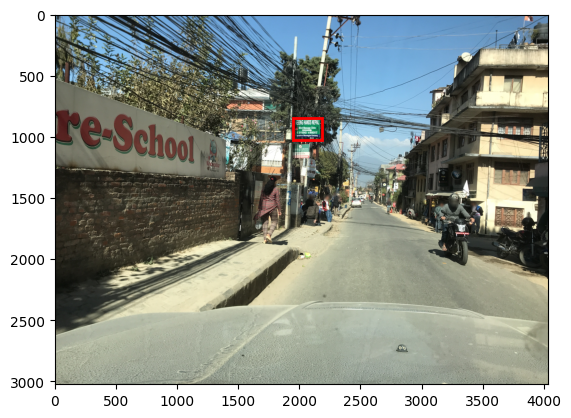

Value: information--highway-interchange--g1
base64_string: GjgKBm1weS1vchIYEgIAABgDIhAJniXMGRrsAQAAyAHrAQAPGgR0eXBlIgkKB3BvbHlnb24ogCB4AQ==
detection_value 'information--highway-interchange--g1' found at index: 0
Yolo Annotation: 0 0.596191 0.412109 0.028809 0.024414
YOLO format annotations:


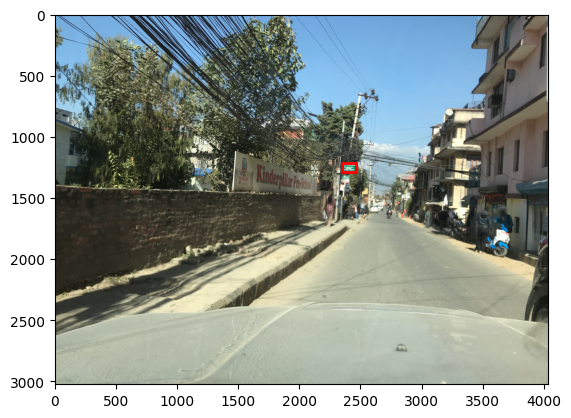

Value: information--highway-interchange--g1
base64_string: GjgKBm1weS1vchIYEgIAABgDIhAJ7BugDBreAgAAkAPdAgAPGgR0eXBlIgkKB3BvbHlnb24ogCB4AQ==
detection_value 'information--highway-interchange--g1' found at index: 0
Yolo Annotation: 0 0.456421 0.215820 0.042725 0.048828
YOLO format annotations:


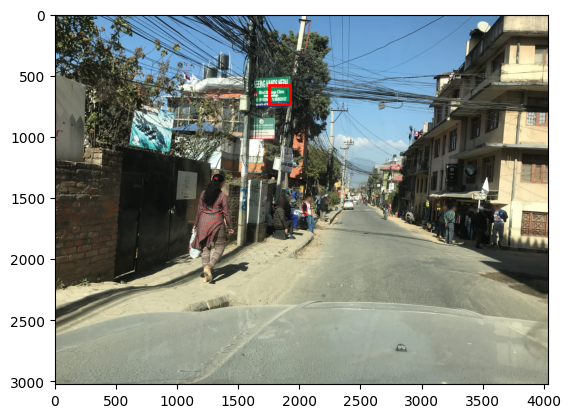

Value: construction--barrier--wall
base64_string: Gmx4AgoGbXB5LW9yKIAgEl0YAwgBIlcJAIw2wgIMBQxJBCYMFhIHDBUDIwQNIDsYCAosEAADFgcGBzQEXggAABsMDwgjA2UIGxAAA0gIDgBCCBYHOhcWGwANDQMODwgHJBMOCywHCBEABx0bBQ8=
Value: construction--barrier--wall
base64_string: GjB4AgoGbXB5LW9yKIAgEiEYAwgBIhsJlBHiGVIcBQwWIgYIFggABA4DHhkOOw0PHQ8=
Value: construction--barrier--wall
base64_string: GiZ4AgoGbXB5LW9yKIAgEhcYAwgBIhEJ2h30FSoIBwQIBBwAHgsODw==
Value: construction--barrier--wall
base64_string: Gj94AgoGbXB5LW9yKIAgEjAYAwgBIioJlirOEIoBBA0iBwwWGAgEFhQHBAgADgAkEw0DHSMIIQ0DDg8ABA0MBw8=
Value: construction--barrier--wall
base64_string: Gn14AgoGbXB5LW9yKIAgEm4YAwgBImgJihr+FPoCFzkDgQEIFQRdDA8MKyYAEA0cR24PFiMYADpBNBMQMxIHDBMEAAAqBBYAQgQOEMwDBCQAQgQyACQAYC8AAwAlDy8AAwUhBxsVAwUHBwsVGQcLFRsNAA0PBwMVERUjFUEIDw==
Value: construction--barrier--wall
base64_string: GpQBeAIKBm1weS1vciiAIBKEARgDCAEifgm4HdIP0gMUCCIyJAgQLBYOMA5CACg5BiMMFSAbBDsYRwQjEh0QADArFggUDTAGIg1KACQWFDQWtAMZFg9ICwgTLIsBWBsACw5FDlEHIRYTAAsQRQ4jFg8kEQ0jBxMkAzQ

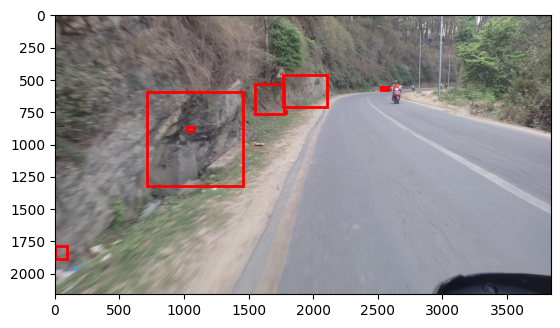

Value: construction--barrier--wall
base64_string: GiZ4AgoGbXB5LW9yKIAgEhcYAwgBIhEJrhzGDSoQBgQ0BwYADREVDw==
Value: construction--barrier--wall
base64_string: GiV4AgoGbXB5LW9yKIAgEhYYAwgBIhAJkh70DiIIFgCKAQMIAw4P
Value: construction--barrier--wall
base64_string: Gkd4AgoGbXB5LW9yKIAgEjgYAwgBIjIJsh/2D6oBEA0mAAwNNAcOFRAFBA8UBQwdEA0WAAQOAB4hLAcqCxZZLAMIIwcJGx8VDw==
Value: construction--barrier--wall
base64_string: GnF4AgoGbXB5LW9yKIAgEmIYAwgBIlwJjhfOF9ICFTMaEwhJCAUAHQsrHSMADQsVBEEWHSQFDAcEDTYHCA0MABQjGhUEJBAkBB4QDggWCAAIFiIcACYcMggAFCwiHhgADBQTHkEWBw4LAAcORSxpHkUHDw==
Value: construction--barrier--wall
base64_string: GkB4AgoGbXB5LW9yKIAgEjEYAwgBIisJ5h2gD4oBBw8JFgcACxUPAAc/CxUADRQHDB0mCAQNDAcIDgDUAQAODyMP
Value: warning--double-curve-first-right--g1
base64_string: GiR4AgoGbXB5LW9yKIAgEhUYAwgBIg8JyB3OCxoAtgFmAAC1AQ8=
detection_value 'construction--barrier--wall' found at index: 4
Yolo Annotation: 4 0.443970 0.215576 0.003174 0.007812
detection_value 'construction--barrier--wall' found at index:

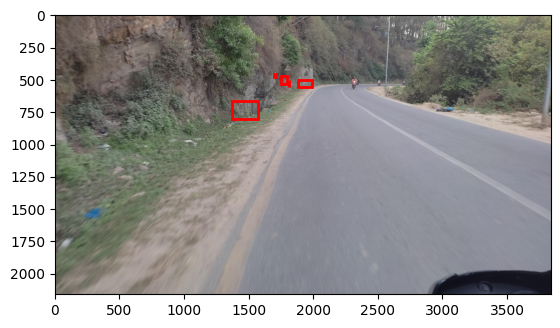

Value: regulatory--no-right-turn--g1
base64_string: GjgKBm1weS1vchIYEgIAABgDIhAJ8AfuGRreAwAAoATdAwAPGgR0eXBlIgkKB3BvbHlnb24ogCB4AQ==
Value: information--pedestrians-crossing--g1
base64_string: GjgKBm1weS1vchIYEgIAABgDIhAJuBPWGxrMAQAAjALLAQAPGgR0eXBlIgkKB3BvbHlnb24ogCB4AQ==
detection_value 'regulatory--no-right-turn--g1' found at index: 3
Yolo Annotation: 3 0.152222 0.437256 0.058350 0.066406
detection_value 'information--pedestrians-crossing--g1' found at index: 2
Yolo Annotation: 2 0.316162 0.448730 0.024902 0.032715
YOLO format annotations:


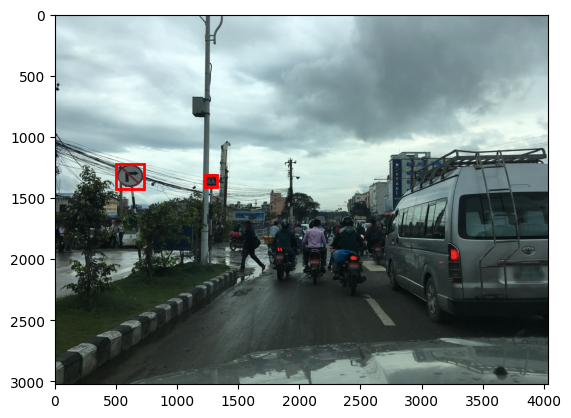

In [153]:
try:
    image_ids = ['477306593503728', '532278331102701', '147107937426847', '395154942435870', '292807716336713','3776981739096254']
    access_token=""
    for image_id in image_ids:
        detections_url = f"https://graph.mapillary.com/{image_id}/detections?access_token={access_token}&fields=geometry,value"
        traffic_signs = get_traffic_signs() 
    
        get_image_infos = get_geometry(detections_url,traffic_signs)
        base64_string,detection_value=get_image_infos
    
        image_path = f"my_images/{image_id}.jpg"
        
        file_name_with_extension = os.path.basename(image_path)
        file_name, _ = os.path.splitext(file_name_with_extension)
        
        os.makedirs("my_labels",exist_ok=True)
        label_file=os.path.join("my_labels",f'{file_name}.txt')
        
        yolo_annotations, bboxes = process_detections(base64_string,detection_value)
        
        print("YOLO format annotations:")
        
        with open(label_file, "w") as f:
            for annotation in yolo_annotations:
                f.write(annotation + "\n")
        
        visualize_annotations(image_path, bboxes)

except Exception as e:
    print(f"An error occurred: {e}")